## Laboratorium 7


## Detekcja obiektów za pomocą Faster-RCNN

### Wprowadzenie

Celem tej listy jest praktyczne zapoznanie się z działaniem dwuetapowych modeli do detekcji obiektów na przykładzie Faster R-CNN. Skorzystamy z gotowej implementacji modelu z pakietu [`torchvision`](https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py). Jeżeli masz inny ulubiony model działający na podobnej zasadzie, możesz z niego skorzystać zamiast podanego. Podobnie implementacja - jeśli masz swoją ulubioną bibliotekę np. Detectron2, MMDetection, możesz z niej skorzystać.

W zadaniu wykorzystany zostanie zbiór danych [_Chess Pieces Dataset_](https://public.roboflow.com/object-detection/chess-full) (autorstwa Roboflow, domena publiczna), ZIP z obrazami i anotacjami powinien być dołączony do instrukcji.

Podczas realizacji tej listy większy nacisk położony zostanie na inferencję z użyciem Faster R-CNN niż na uczenie (które przeprowadzisz raz\*). Kluczowe komponenty w tej architekturze (RPN i RoIHeads) można konfigurować bez ponownego uczenia, dlatego badania skupią się na ich strojeniu. Aby zrozumieć działanie modelu, konieczne będzie spojrzenie w jego głąb, włącznie z częściowym wykonaniem. W tym celu warto mieć na podorędziu kod źródłowy, w szczególności implementacje następujących klas (uwaga - linki do najnowszej implementacji; upewnij się więc, że czytasz kod używanej przez siebie wersji biblioteki):
* `FasterRCNN`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py
* `GeneralizedRCNN`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/generalized_rcnn.py
* `RegionProposalNetwork`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
* `RoIHeads`: https://github.com/pytorch/vision/blob/main/torchvision/models/detection/roi_heads.py

Dogłębne zrozumienie procedury uczenia modelu nie będzie wymagane, niemniej należy mieć ogólną świadomość jak ten proces przebiega i jakie funkcje kosztu są wykorzystywane. Użyjemy gotowej implementacji z submodułu [`references.detection`](https://github.com/pytorch/vision/blob/main/references/detection/train.py) w nieco uproszczonej wersji. Ponieważ ten moduł **nie** jest domyślnie instalowaną częścią pakietu `torchvision`, do instrukcji dołączono jego kod w nieznacznie zmodyfikowanej wersji (`references_detection.zip`).
Jeśli ciekawią Cię szczegóły procesu uczenia, zachęcam do lektury [artykułu](https://arxiv.org/abs/1506.01497) i analizy kodu implementacji.

In [2]:
# !pip install pycocotools

In [3]:
# pip install torchvision>=0.13

### Zadanie 0: Uczenie

Krokiem "zerowym" będzie przygotowanie wstępnie nauczonego modelu i douczenie go na docelowym zbiorze.
Podany zestaw hiperparametrów powinien dawać przyzwoite (niekoniecznie idealne) wyniki - jeśli chcesz, śmiało dobierz swoje własne; nie spędzaj na tym jednak zbyt wiele czasu.

Twoim zadaniem jest nie tylko przeklikanie poniższych komórek, ale przynajmniej ogólne zrozumienie procesu uczenia (przejrzyj implementację `train_one_epoch`) i struktury modelu.

In [1]:
import os
import time
import datetime
import pickle

import torch
import torch.utils.data
import torchvision
import torchvision.models.detection as M
from torchvision.io.image import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection.faster_rcnn import FasterRCNN

from detection import coco_utils, presets, utils, transforms
from detection.engine import train_one_epoch, evaluate
from tqdm.notebook import tqdm

In [2]:
def get_dataset(img_root:str, file_name:str, train:bool=True):
  """Reimplementacja analogicznej funkcji z pakietu references, rozwiązująca drobną niekompatybilność w zbiorze CPD"""
  def fake_segmentation(image, target):
    for obj in target['annotations']:
      x, y, w, h = obj['bbox']
      segm = [x, y, x+w, y, x+w, y+h, x, y+h]
      obj['segmentation'] = [segm]
    return image, target

  tfs = transforms.Compose([
    fake_segmentation,
    coco_utils.ConvertCocoPolysToMask(),
    presets.DetectionPresetTrain(data_augmentation='hflip') if train else presets.DetectionPresetEval(),
    # jeśli chcesz dodać swoje własne augmentacje, możesz zrobić to tutaj
  ])
  ds = coco_utils.CocoDetection(img_root, file_name, transforms=tfs)
  return ds

In [13]:
# Konfiguracja hiperparametrów
LR = 0.001 # powinno być dobrze dla 1 GPU
WDECAY = 0.0001
EPOCHS = 25
VAL_FREQ = 5 # walidacja i checkpointowanie co N epok
BATCH_SIZE = 4 # dobierz pod możliwości sprzętowe
NUM_WORKERS = 0 # j/w
NUM_CLASSES = 14
DEVICE = 'cuda:0'
# DEVICE = 'cpu'
DATASET_ROOT = 'chess/'
OUTPUT_DIR = 'out2/'
MODEL_PATH = os.path.join(OUTPUT_DIR, 'model_2_24.pth')

In [4]:
# Zaczytanie datasetów
chess_train = get_dataset(os.path.join(DATASET_ROOT, 'train'), os.path.join(DATASET_ROOT, 'train/_annotations.coco.json'))
chess_val = get_dataset(os.path.join(DATASET_ROOT, 'valid'), os.path.join(DATASET_ROOT, 'valid/_annotations.coco.json'))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
# samplery i loadery
train_sampler = torch.utils.data.RandomSampler(chess_train)
train_batch_sampler = torch.utils.data.BatchSampler(train_sampler, BATCH_SIZE, drop_last=True)
train_loader = torch.utils.data.DataLoader(
  chess_train, batch_sampler=train_batch_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

val_sampler = torch.utils.data.SequentialSampler(chess_val)
val_loader = torch.utils.data.DataLoader(
  chess_val, batch_size=1, sampler=val_sampler, num_workers=NUM_WORKERS, collate_fn=utils.collate_fn
)

In [6]:
# Skonstruowanie modelu; tworzymy w wersji dla 91 klas aby zainicjować wagi wstępnie nauczone na COCO...
model = M.fasterrcnn_resnet50_fpn(weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, num_classes=91).to(DEVICE)
# ...po czym zastępujemy predyktor mniejszym, dostosowanym do naszego zbioru:
model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_channels=1024, num_classes=NUM_CLASSES).to(DEVICE)

In [9]:
model # zwróć uwagę na strukturę Box Predictora (dlaczego tyle out_features?)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Zanim przejdziemy do uczenia pełnego modelu, wykonamy krótkie wstępne uczenie losowo zainicjowanego predyktora:
train_one_epoch(
  model=model,
  optimizer=torch.optim.AdamW(model.roi_heads.box_predictor.parameters(), lr=LR, weight_decay=WDECAY),
  data_loader=train_loader,
  device=DEVICE,
  epoch=0, print_freq=20, scaler=None
)

In [7]:
# Uczenie pełnego modelu
optimizer = torch.optim.AdamW(
  [p for p in model.parameters() if p.requires_grad],
  lr=LR,
  weight_decay=WDECAY
)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1) # dobierz wartości jeśli trzeba

start_time = time.time()
for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_loader, DEVICE, epoch, 10, None)
    lr_scheduler.step()

    # eval and checkpoint every VAL_FREQ epochs
    if (epoch+1) % VAL_FREQ == 0:
      checkpoint = {
          "model": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "lr_scheduler": lr_scheduler.state_dict(),
          "epoch": epoch,
      }
      utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, f"model_2_{epoch}.pth"))
      utils.save_on_master(checkpoint, os.path.join(OUTPUT_DIR, "checkpoint.pth"))
      evaluate(model, val_loader, device=DEVICE)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f"Training time {total_time_str}")

Epoch: [0]  [ 0/50]  eta: 0:02:04  lr: 0.000021  loss: 2.7665 (2.7665)  loss_classifier: 2.3124 (2.3124)  loss_box_reg: 0.2657 (0.2657)  loss_objectness: 0.1811 (0.1811)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 2.4929  data: 0.2203  max mem: 4609
Epoch: [0]  [10/50]  eta: 0:02:14  lr: 0.000225  loss: 1.3769 (1.6666)  loss_classifier: 0.6934 (1.1400)  loss_box_reg: 0.4011 (0.4521)  loss_objectness: 0.0039 (0.0522)  loss_rpn_box_reg: 0.0149 (0.0224)  time: 3.3570  data: 0.3524  max mem: 5094
Epoch: [0]  [20/50]  eta: 0:01:38  lr: 0.000429  loss: 1.1130 (1.2784)  loss_classifier: 0.6093 (0.8066)  loss_box_reg: 0.3911 (0.4170)  loss_objectness: 0.0039 (0.0297)  loss_rpn_box_reg: 0.0205 (0.0251)  time: 3.3184  data: 0.3588  max mem: 5126
Epoch: [0]  [30/50]  eta: 0:01:11  lr: 0.000633  loss: 0.7975 (1.1235)  loss_classifier: 0.4249 (0.6855)  loss_box_reg: 0.3341 (0.3917)  loss_objectness: 0.0039 (0.0211)  loss_rpn_box_reg: 0.0212 (0.0253)  time: 3.6631  data: 0.3830  max mem: 5126
Epoch: [

In [14]:
import pickle
with open('./model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [8]:
import pickle
with open('./model.pkl', 'rb') as file:
    model = pickle.load(file)

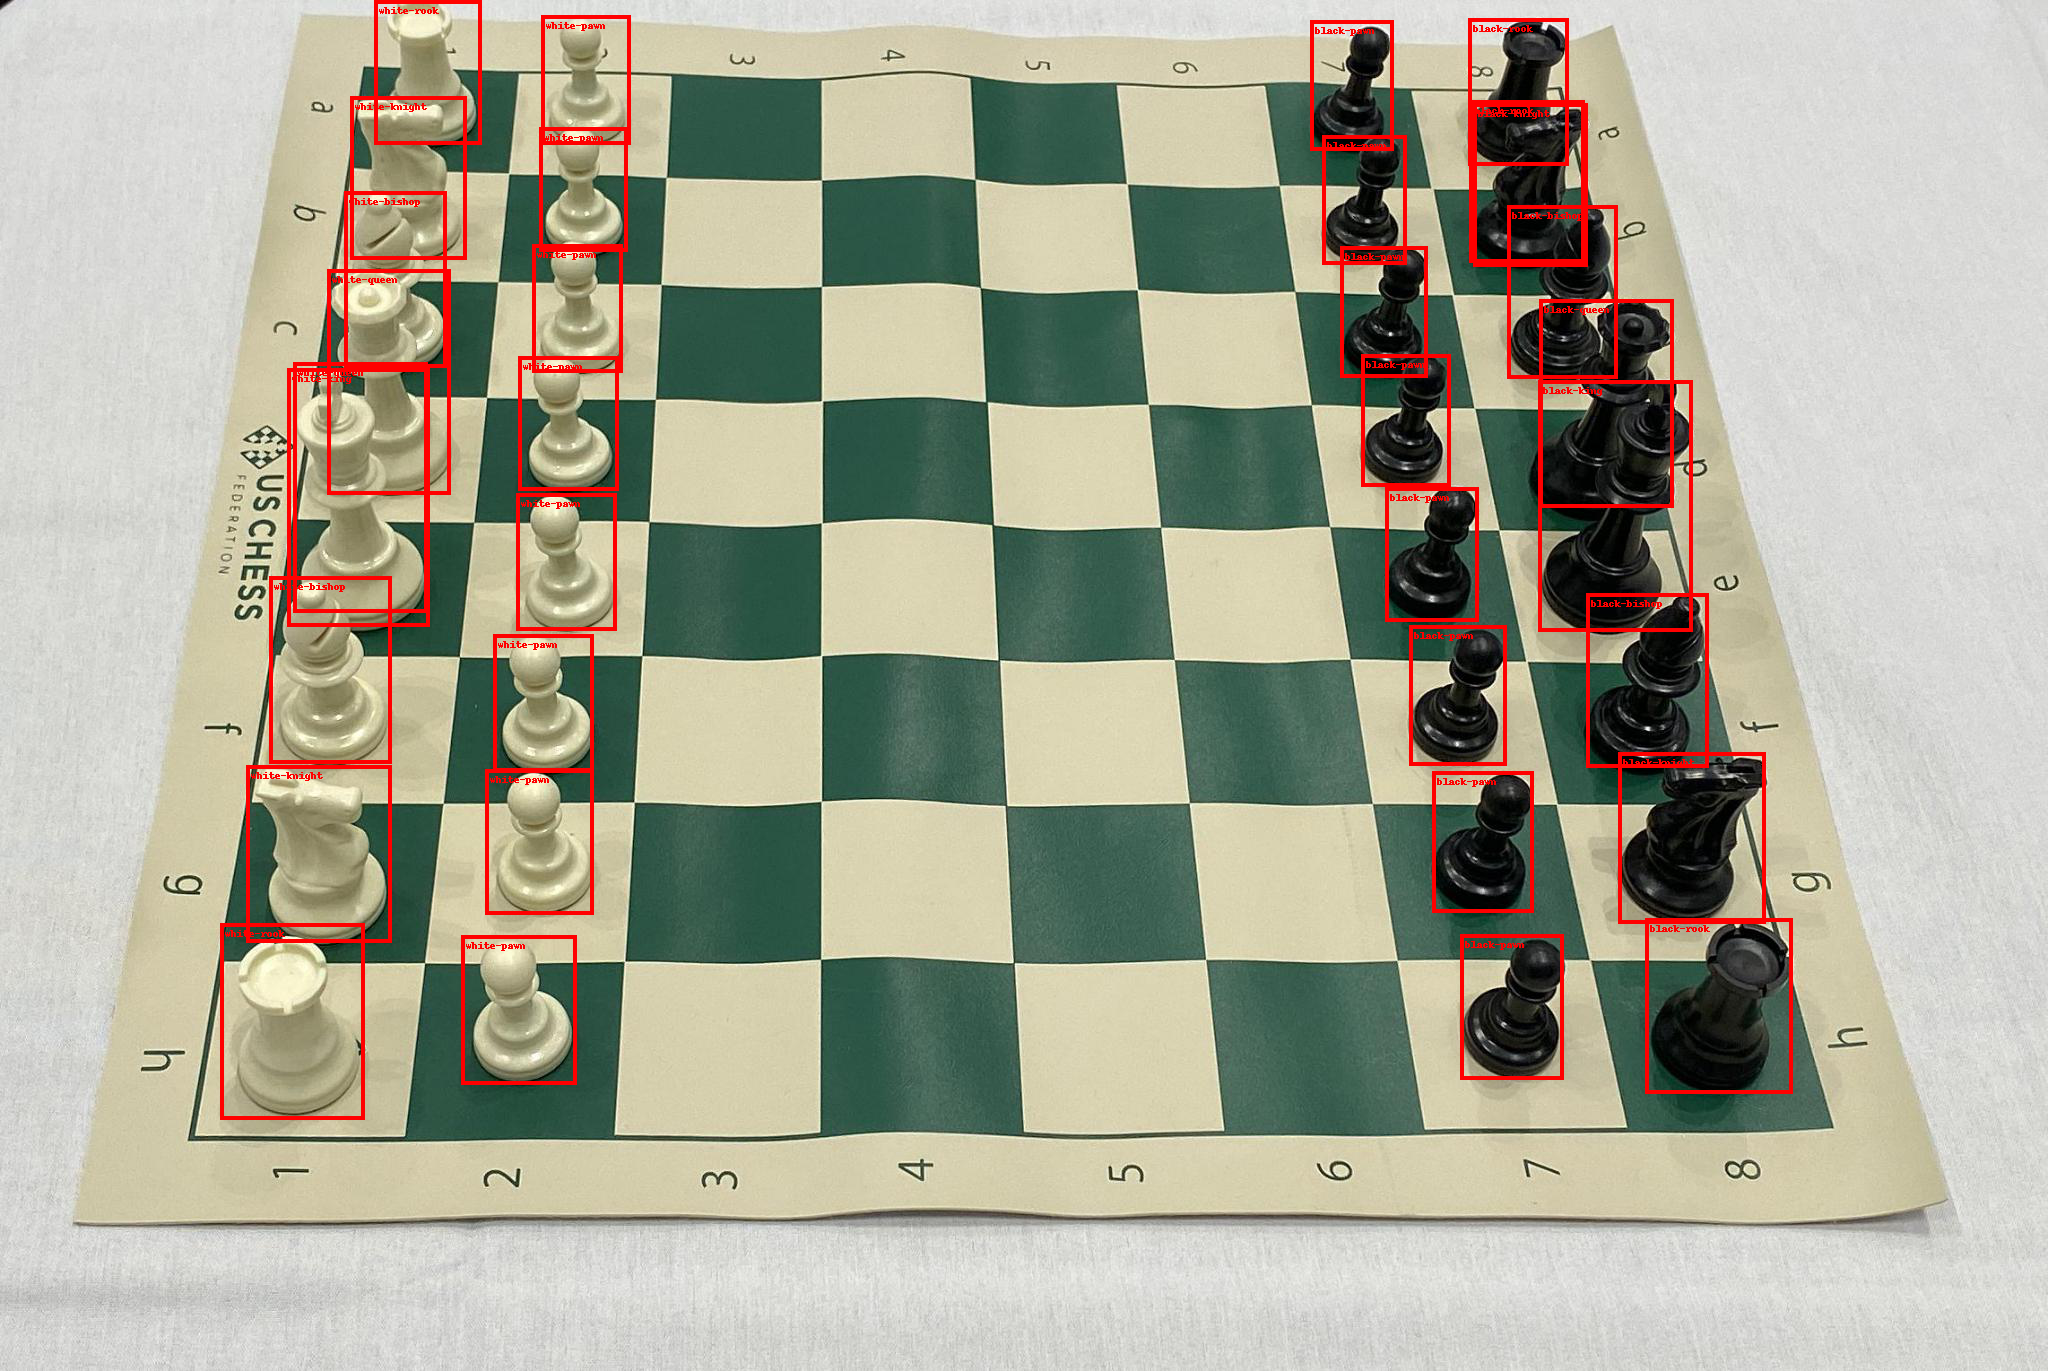

In [8]:
# Inferencja na zadanym obrazie
preprocess = M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms() # to wystarczy pobrać raz
img = read_image(os.path.join(DATASET_ROOT, 'test/IMG_0159_JPG.rf.1cf4f243b5072d63e492711720df35f7.jpg'))
batch = [preprocess(img).to(DEVICE)]
prediction = model(batch)[0]
# Rysowanie predykcji - wygodny gotowiec
box = draw_bounding_boxes(
  img,
  boxes=prediction['boxes'],
  labels=[chess_train.coco.cats[i.item()]['name'] for i in prediction['labels']],
  colors='red',
  width=4,
)
to_pil_image(box.detach())

---
### Zadanie 1

Zbadaj wpływ parametrów inferencji **głowic `RoIHeads`**, progu prawdopodobieństwa (`score_thresh`) i progu NMS (`nms_thresh`), na działanie modelu. Wykorzystaj funkcję `evaluate` aby zmierzyć zmianę jakości predykcji, ale przebadaj też efekty wizualnie, wyświetlając predykcje dla kilku obrazów ze zbioru walidacyjnego i kilku spoza zbioru (folder `wild`). _W finalnej wersji pozostaw tylko wybrane interesujące przykłady._

In [35]:
IMAGES = [
    os.path.join(DATASET_ROOT, "test", "e0d38d159ad3a801d0304d7e275812cc_jpg.rf.fa0bb8160816a373df824349a24a11e7.jpg"),
    os.path.join(DATASET_ROOT, "test", "685b860d412b91f5d4f7f9e643b84452_jpg.rf.5ba8dc0b5d2585d01b28089debd42cd6.jpg"),
    os.path.join(DATASET_ROOT, "test", "b9402881fa580d0eb8b9b98845417550_jpg.rf.087d716cdfdd9cf2cb65b437af716d4d.jpg"),
    os.path.join("wild", "chesscom_fide.jpeg"),
    os.path.join("wild", "chesscom_uscf.jpeg"),
    os.path.join("wild", "shop.jpg")
]

NMS - non maximum supression

In [9]:
import sys; sys.path.append('..')
from detection.coco_eval import CocoEvaluator


def load_trained_model(path: str, score_threshold: float, nms_threshold: float) -> FasterRCNN:
    model = M.fasterrcnn_resnet50_fpn(
        weights=M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1, 
        num_classes=91,        
        box_score_thresh=score_threshold,  # (default 0.05) during inference, only return proposals with a classification score greater than box_score_thresh
        box_nms_thresh=nms_threshold       # (default 0.5) selects bbox with score above threshold
    ).to(DEVICE)

    model.roi_heads.box_predictor = M.faster_rcnn.FastRCNNPredictor(in_channels=1024, num_classes=NUM_CLASSES).to(DEVICE)
    model.load_state_dict(torch.load(path)["model"])
    model.eval()

    return model


def evaluate_roiheads(model_path: str, score_thresholds: list[float], nms_thresholds: list[float]) -> list[CocoEvaluator]:
    chess_test = get_dataset(
        os.path.join(DATASET_ROOT, 'test'), 
        os.path.join(DATASET_ROOT, 'test/_annotations.coco.json')
    )

    test_loader = torch.utils.data.DataLoader(
        chess_test, 
        batch_size=1, 
        num_workers=NUM_WORKERS, 
        collate_fn=utils.collate_fn
    )

    evaluators = []
    for score_thresh in tqdm(score_thresholds):
        for nms_thresh in tqdm(nms_thresholds, leave=False):
            model = load_trained_model(
                path=model_path,
                score_threshold=score_thresh, 
                nms_threshold=nms_thresh
            )

            evaluator: CocoEvaluator = evaluate(model, test_loader, DEVICE)
            evaluators.append(evaluator)
    return evaluators



In [ ]:
[0.01, 0.02, 0.05, 0.10, 0.20, 0.50]
evals = evaluate_roiheads(MODEL_PATH, [0.50], [0.5])

### Wpływ parametru `score_threshold` (`nms_threshold = 0.5`):

|score threshold|AP IoU=0.50:0.95|AP IoU=0.50|AP IoU=0.75|AR maxDets=1|AR maxDets=10|AR maxDets=100|
|--------------:|---------------:|----------:|----------:|-----------:|------------:|-------------:|
|0.01|0.268|0.334|0.330|0.289|0.439|0.439|
|0.02|0.185|0.229|0.216|0.230|0.354|0.354|
|0.05|**0.382**|**0.473**|**0.465**|**0.361**|**0.537**|**0.537**|
|0.10|0.133|0.163|0.162|0.177|0.268|0.268|
|0.20|0.219|0.269|0.262|0.262|0.381|0.381|
|0.50|0.214|0.266|0.260|0.255|0.387|0.387|

In [ ]:
[0.01, 0.10, 0.40, 0.50, 0.60, 0.70, 0.99]
evals = evaluate_roiheads(MODEL_PATH, [0.05], [0.99])

### Wpływ parametru `nms_threshold` (`score_threshold = 0.05`):
|score threshold|AP IoU=0.50:0.95|AP IoU=0.50|AP IoU=0.75|AR maxDets=1|AR maxDets=10|AR maxDets=100|
|--------------:|---------------:|----------:|----------:|-----------:|------------:|-------------:|
|0.01|0.161|0.198|0.190|0.229|0.322|0.322|
|0.10|0.248|0.307|0.299|0.263|0.409|0.409|
|0.40|0.254|0.317|0.311|0.279|0.436|0.436|
|0.50|**0.341**|**0.414**|**0.409**|**0.325**|**0.484**|**0.484**|
|0.60|0.247|0.300|0.299|0.265|0.401|0.401|
|0.70|0.162|0.206|0.193|0.207|0.320|0.320|
|0.99|0.140|0.176|0.172|0.240|0.318|0.331|

In [48]:
import matplotlib.pyplot as plt
from typing import Literal

def plot_parameter_threshold_examples(image_paths: list[str], parameter: list[float], param_name: Literal['score', 'nms']):
    assert param_name in ['score', 'nms']
    _, axes = plt.subplots(len(image_paths), len(parameter), figsize=(30, 35))
    preprocess = M.FasterRCNN_ResNet50_FPN_Weights.COCO_V1.transforms()

    for ax, image_path in tqdm(zip(axes, image_paths), total=len(image_paths)):
        for i, param in enumerate(parameter):
            model = load_trained_model(
                path=MODEL_PATH,
                score_threshold=param if param_name == 'score' else 0.05,
                nms_threshold=param if param_name == 'nms' else 0.5
            )
            image = read_image(image_path)
            batch = [preprocess(image).to(DEVICE)]
            prediction = model(batch)[0]

            image = draw_bounding_boxes(
                image,
                boxes=prediction['boxes'],
                labels=[chess_train.coco.cats[i.item()]['name'] for i in prediction['labels']],
                colors='red',
                width=4,
            )
            image = to_pil_image(image.detach())
            
            ax[i].imshow(image)
            ax[i].set_title(f"score threshold={param if param_name == 'score' else 0.05}, nms threshold={param if param_name == 'nms' else 0.5}")
            ax[i].axis("off")

  0%|          | 0/6 [00:00<?, ?it/s]

d:\HDD\Studia\Mgr_sem_2\analiza_i_przetwarzanie_obrazow_i_wideo\venvs\lib\site-packages\torchvision\utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


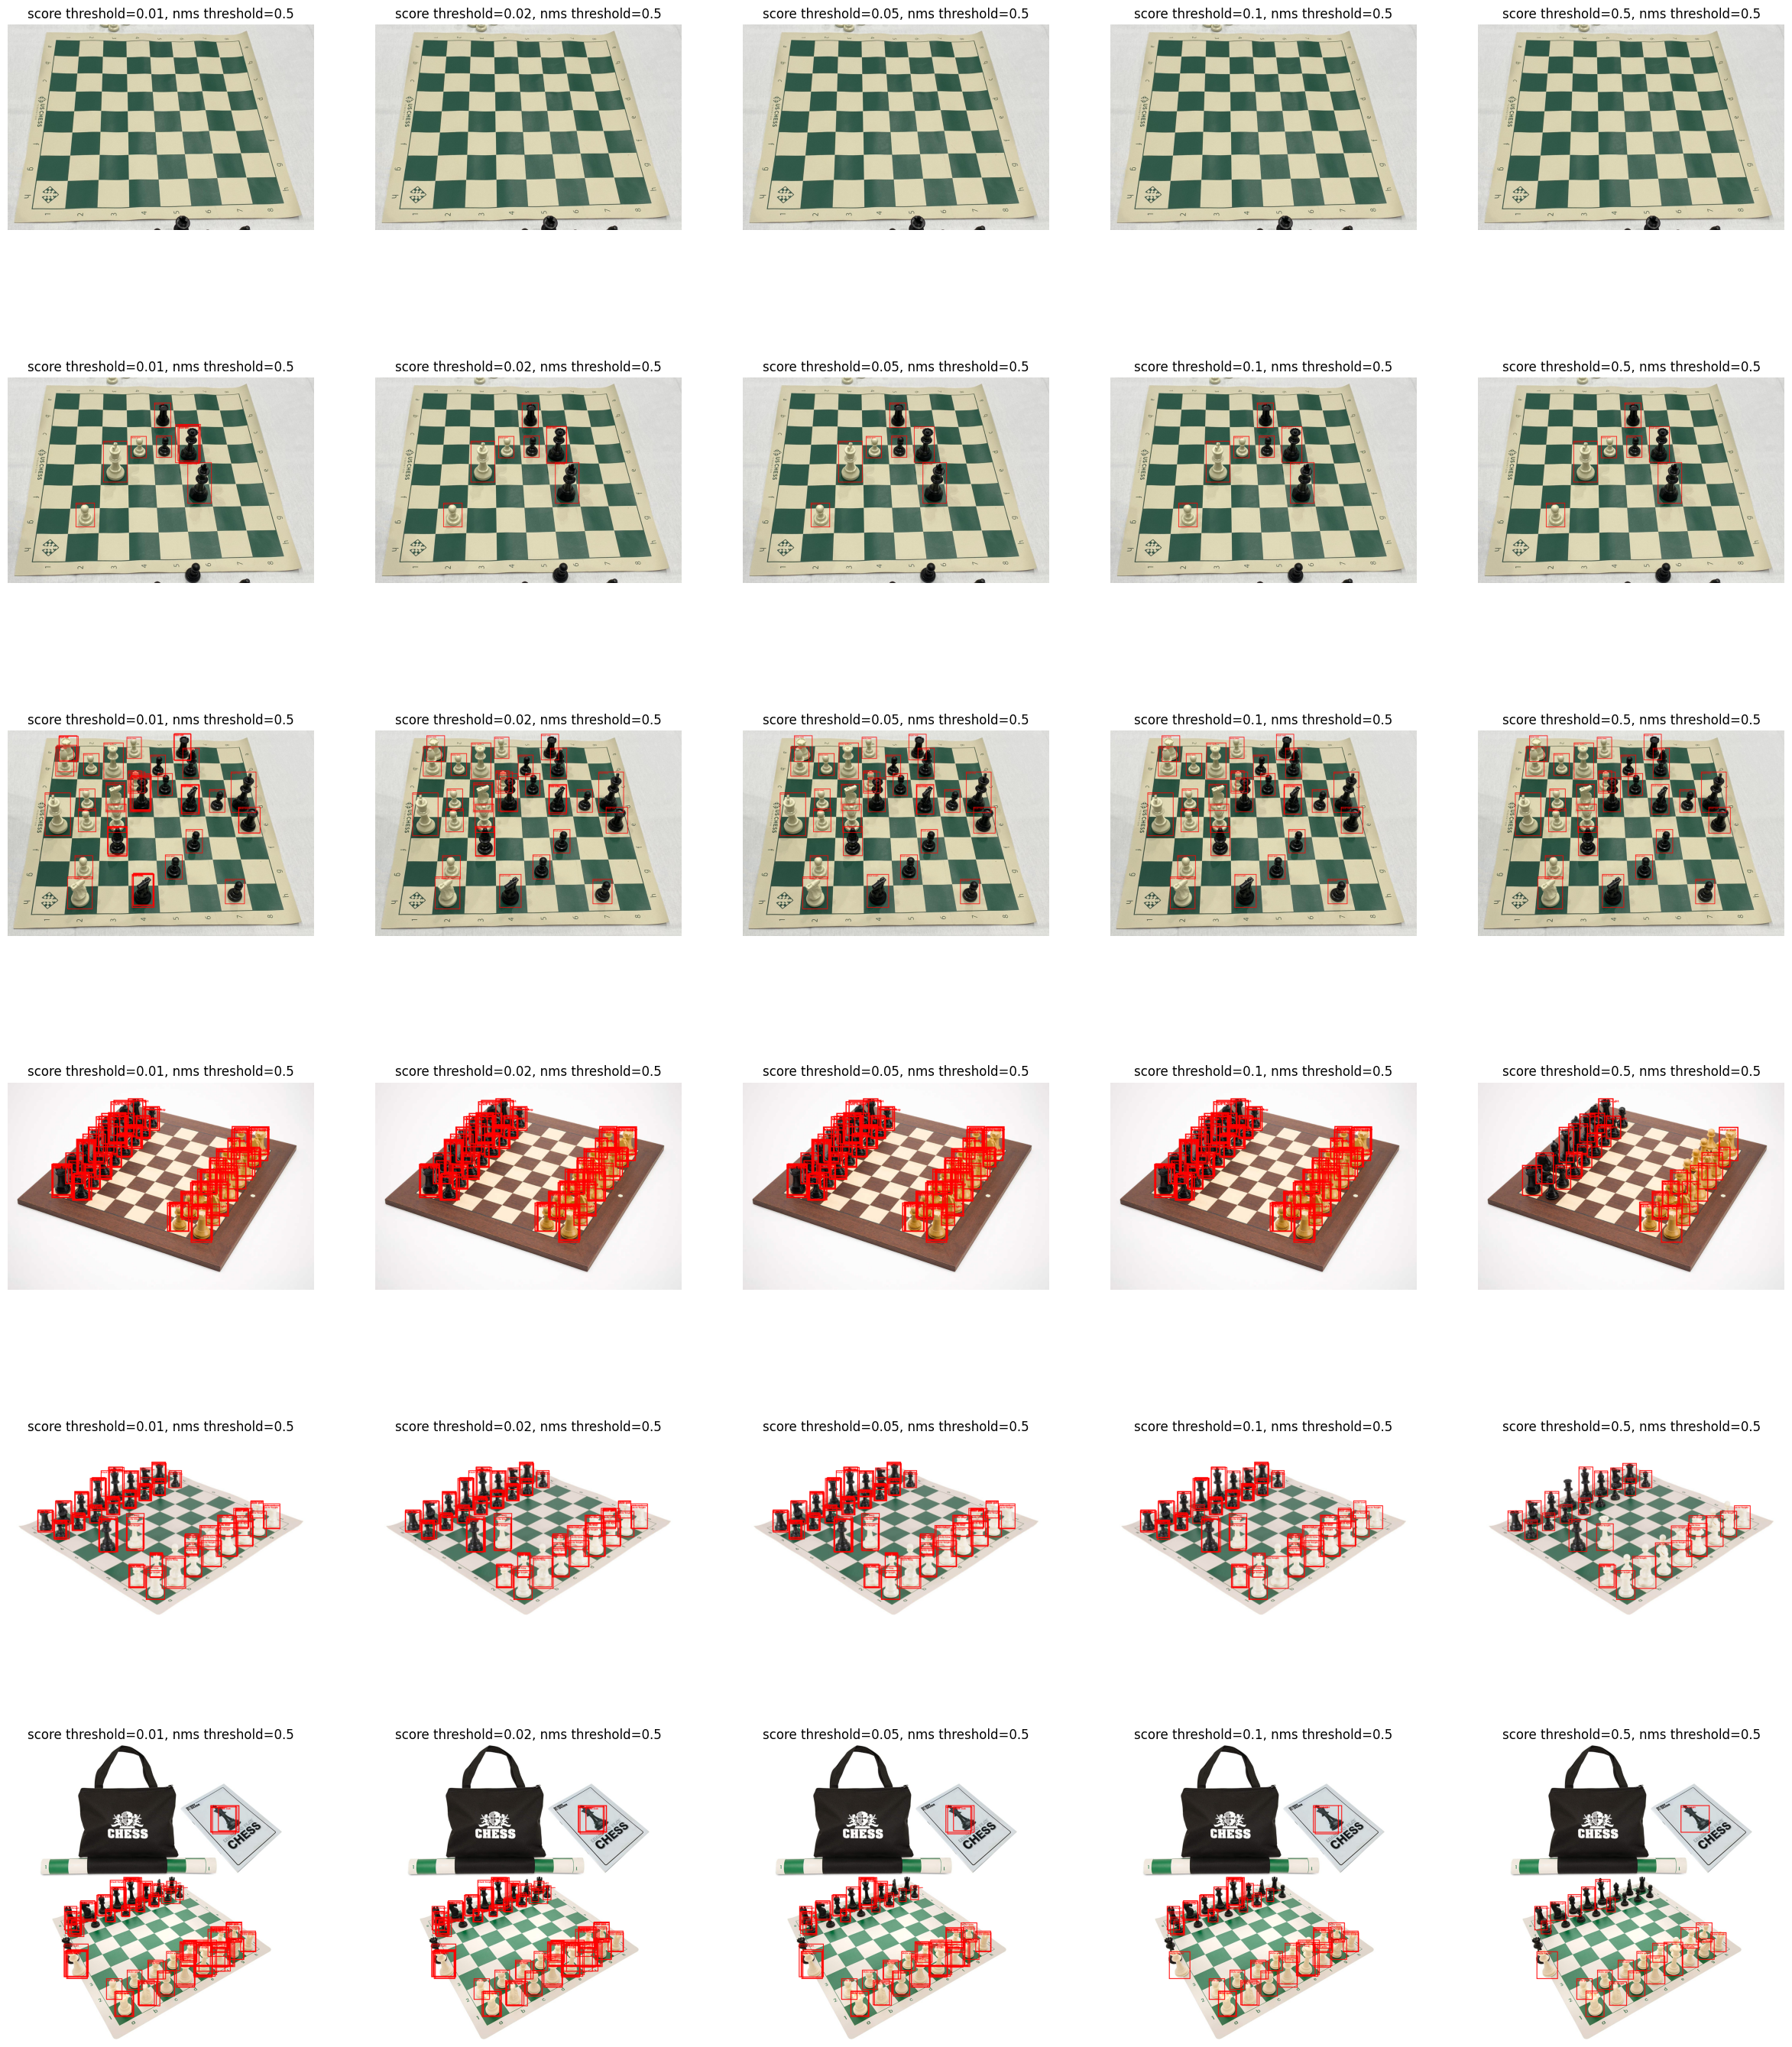

In [49]:
plot_parameter_threshold_examples(IMAGES, [0.01, 0.02, 0.05, 0.10, 0.50], param_name='score')

### Zadanie 2a

Zwizualizuj propozycje rejonów wygenerowane przez RPN i porównaj z ostateczną predykcją.

W tym celu konieczne będzie manualne wykonanie fragmentu metody `GeneralizedRCNN::forward` (patrz: [kod](https://github.com/pytorch/vision/blob/c35d3855ccbfa6a36e6ae6337a1f2c721c1f1e78/torchvision/models/detection/generalized_rcnn.py#L46), link do wersji najnowszej na listopad 2023).
Wszystkie fragmenty związane z uczeniem możesz rzecz jasna pominąć; chodzi o wyciągnięcie obiektu `proposals`.
Nie zapomnij o wykonaniu powrotnej transformacji! (Po co?)

### Zadanie 2b

Zbadaj wpływ progu NMS _na etapie propozycji_ na jakość predykcji oraz czas ich uzyskania.
Jak w poprzednich zadaniach, postaraj się nie ograniczyć tylko do pokazania metryk, ale pokaż wizualizacje (propozycji i predykcji) dla **wybranych** przykładów.